In [1]:
# Import des libraries

from bigml.api import BigML
import matplotlib.pyplot as plt

In [6]:
# Connexion au projet via l'API de BIG ML

api = BigML('MAXIMEFAVOT', '69757fb108f0bd7a8678e0b66e3de66ae6478c81', project='project/5d9e081659f5c320e1000597')

In [7]:
# Creation des sources sur BigML

source_train = api.create_source('https://oml-data.s3.amazonaws.com/kaggle-give-me-credit-train.csv')

In [8]:
# On crée un dataset à partir de la source puis on split (Val et Test)

train_full = api.create_dataset(source_train, {"name": "Train Full"})
val_set = api.create_dataset(train_full, {"name": "Val_set", "sample_rate": 0.8, "seed": "my seed"})
test_set = api.create_dataset(train_full, {"name": "Test_set", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})

In [9]:
# creation des listes vides pour contenir l'abscisse (taille du dataset) et l'ordonnée (AUC) pour le modele ensemble et deepnet

x_ensemble = []
y_ensemble = []
x_deepnet = []
y_deepnet = []

for i in range(1,11): # On fait une boucle pour faire varier de 10 à 100 % de lignes du dataset Val_set
   
    # On crée le nouveau dataset de train à partir du dataset de train initial
    train_set = api.create_dataset(val_set, {"name": "Train Set " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
    api.ok(val_set)   
   
    # On crée le modèle (ensemble) à partir du train_set
    ensemble = api.create_ensemble(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
   
    # On évalue le modèle ensemble (avec le test_set)
    evaluation = api.create_evaluation(ensemble, test_set)
    api.ok(evaluation)
   
    # On crée le modèle (deepnet) à partir du train_set
    deepnet = api.create_deepnet(train_set, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
   
    # On évalue le modèle deepnet (avec le test_set)
    evaluation_deepnet = api.create_evaluation(deepnet, test_set)
    api.ok(evaluation_deepnet)

    # On stocke dans une liste la valeur de l'axe des abscisses (graph_x) et la valeur de l'AUC (graph_y) à partir de la donnée BigML
    x_ensemble.append(i*10)
    y_ensemble.append(evaluation['object']['result']['model']['average_area_under_roc_curve'])
    
    x_deepnet.append(i*10)
    y_deepnet.append(evaluation_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    
    # On itere de 1 le compteur i et on recommence la boucle
    i += 1

# On imprime les resultats
    
print(x_ensemble)
print(y_ensemble)
print(x_deepnet)
print(y_deepnet)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.8268, 0.84703, 0.84842, 0.85246, 0.85309, 0.85359, 0.85282, 0.85293, 0.85461, 0.85501]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.81831, 0.8223, 0.83525, 0.82907, 0.83155, 0.82001, 0.82901, 0.82621, 0.83725, 0.83556]


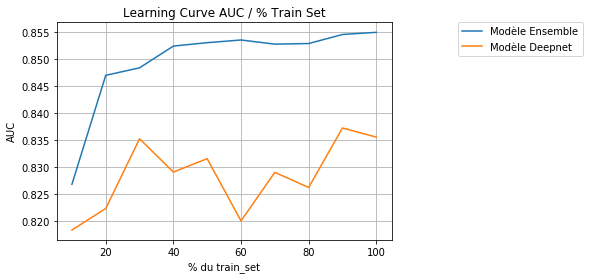

In [17]:
# On cree le graphique du modele deepnet et ensemble (AUC en fonction de la taille du dataset)

fig, ax = plt.subplots()
ax.plot(x_ensemble, y_ensemble, label='Modèle Ensemble')
ax.plot(x_deepnet, y_deepnet, label='Modèle Deepnet')
ax.set(xlabel='% du train_set', ylabel='AUC',  title='Learning Curve AUC / % Train Set')
plt.legend(bbox_to_anchor=(1.2, 1), loc='best', borderaxespad=0.)
ax.grid()
plt.show()